# Pryngles Tutorials: Developers
## Part 6 - Legacy with reflection

This notebook illustrate in detail the interface of the `Pryngles` package. It is especially intended for developers.

Authors:
- Jorge I. Zuluaga, [jorge.zuluaga@udea.edu.co](mailto:jorge.zuluaga@udea.edu.co)

Warnings:
- This file was prepared using version 0.7.3.1 of `Pryngles`.
- It is still working under version 0.9.0.
- Matplotlib commands run in version 3.5.2.

<center><font color='red' size='8'><i>This tutorial is under construction.</i></font></center>

## Preparation

Before running this tutorial you need to install `Pryngles`:

In [1]:
#!python -m pip install -qU pryngles
#!pip show pryngles

If you are running this tutrial in `Google Colab` please run the following lines:

In [2]:
"""
import matplotlib.pyplot as plt
RESOLUTION = 150
%matplotlib inline
plt.rcParams['figure.dpi'] = RESOLUTION
# Sometimes you need to run twice this magic to be sure the backend is loaded
%matplotlib inline
#""";

## Import useful packages

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Although it is not a good practice to import everything of a package, for this tutorial and to avoid excesively large names we will import everything from Pryngles:

In [5]:
from pryngles import *
from pryngles import pixx
import time
#extension="pixx"
extension="cpixx"

## Update Reflection method

This code is intended to test the updateReflection method contributed by Allard to the legacy module.

Create system:

In [6]:
sys_test = System()
s=sys_test.add(kind="Star",physics=dict(radius=Consts.rsun/sys_test.ul),optics=dict(limb_coeffs=[0.65]))
p=sys_test.add(kind="Planet", primary=s,
               orbit=dict(a=3, e=0.0),
               physics=dict(radius=Consts.rsaturn/sys_test.ul),
               optics=dict(nspangles=5000))
r=sys_test.add(kind="Ring", primary=p,
               physics=dict(fi=1.5, fe=2.25, i=30*Consts.deg),
               optics=dict(nspangles=5000))
RP_test=sys_test.ensamble_system(extension=extension)

Initialize orbit:

In [7]:
RP_test.changeObserver([-90*Consts.deg,60*Consts.deg])

# Star apparant size
thetas=RP_test.thetas

# Range of stellar longitude
lamb_initial=90*Consts.deg
lamb_final=450*Consts.deg
lambs=np.linspace(lamb_initial,lamb_final,181)

Inspect the starting position of system:

<IPython.core.display.Javascript object>


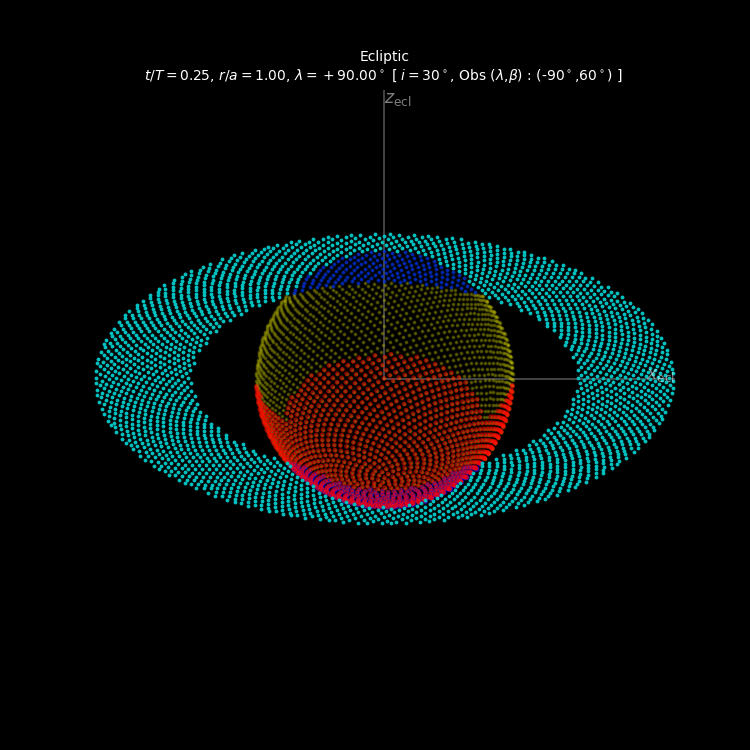

<IPython.core.display.Javascript object>


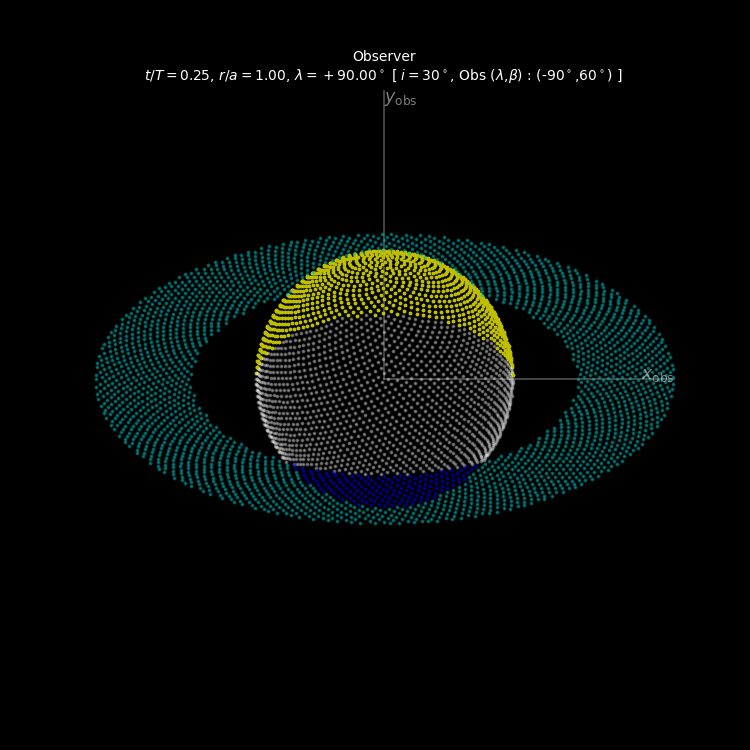

<IPython.core.display.Javascript object>


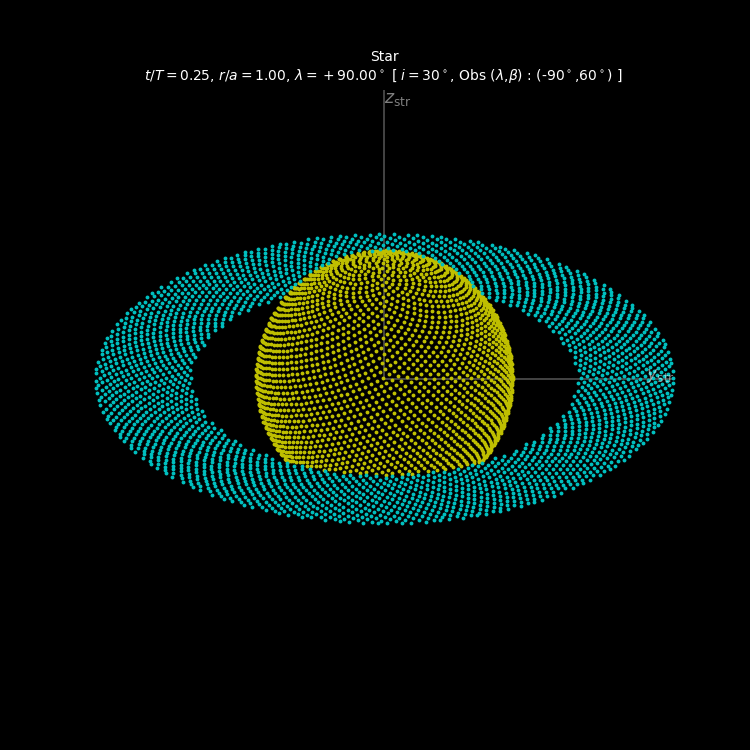

(<Figure size 600x600 with 1 Axes>,
 <Figure size 600x600 with 1 Axes>,
 <Figure size 600x600 with 1 Axes>)

In [8]:
RP_test.changeStellarPosition(90*Consts.deg)
RP_test._updateGeometricalFactors()
RP_test.plotRingedPlanet(showstar=True)

That looks correct! Now let's compute the fluxes:

In [9]:
# New
Rps_test=[]
Rrs_test=[]
Pp = []
Pr = []
Ptot=[]
Qr=[]
Qp=[]
Qtot=[]
Ur=[]
Up=[]
Utot=[]
alpha=[]
ts_test=[]
Tp_test = []
Tr_test = []
T_test = []


reflec_time = []
for lamb in tqdm(lambs):
    st = time.time()
    RP_test.changeStellarPosition(lamb)
    ts_test+=[RP_test.t*RP_test.CU.UT]

    RP_test.updateOpticalFactors()
    et = time.time()
    
    st = time.time()
    RP_test.updateReflection()
    et = time.time()
    reflec_time += [et-st]
    
    Rps_test+=[RP_test.Rip.sum()]
    Rrs_test+=[RP_test.Rir.sum()]
    Pp += [RP_test.Ptotp]
    Pr += [RP_test.Ptotr]
    Ptot+=[RP_test.Ptot]
    Qr+=[RP_test.Stotr[1]]
    Qp+=[RP_test.Stotp[1]]
    Qtot+=[RP_test.Stot[1]]
    Ur+=[RP_test.Stotr[2]]
    Up+=[RP_test.Stotp[2]]
    Utot+=[RP_test.Stot[2]]
    alpha+=[np.arccos(RP_test.alphaps)*180/np.pi]

100%|██████████| 181/181 [00:14<00:00, 12.24it/s]


Compute statistics:

In [10]:
# New
ts_test=np.array(ts_test)
Rps_test=np.array(Rps_test)
Rrs_test=np.array(Rrs_test)
Pp=np.array(Pp)
Pr=np.array(Pr)
Ptot=np.array(Ptot)
Qr=np.array(Qr)
Qp=np.array(Qp)
Qtot=np.array(Qtot)
Ur=np.array(Ur)
Up=np.array(Up)
Utot=np.array(Utot)
alpha=np.array(alpha)
Tp_test = np.array(Tp_test)
Tr_test = np.array(Tr_test)
T_test = np.array(T_test)

ind = np.argmax(alpha)
indstart = np.argsort(alpha)[0]

reflec_time = np.array(reflec_time)
print("Average reflection time: ", np.mean(reflec_time))

ts_test=(ts_test-ts_test[0])/Consts.day

Average reflection time:  0.0705701409123879


Flux curves:

<IPython.core.display.Javascript object>


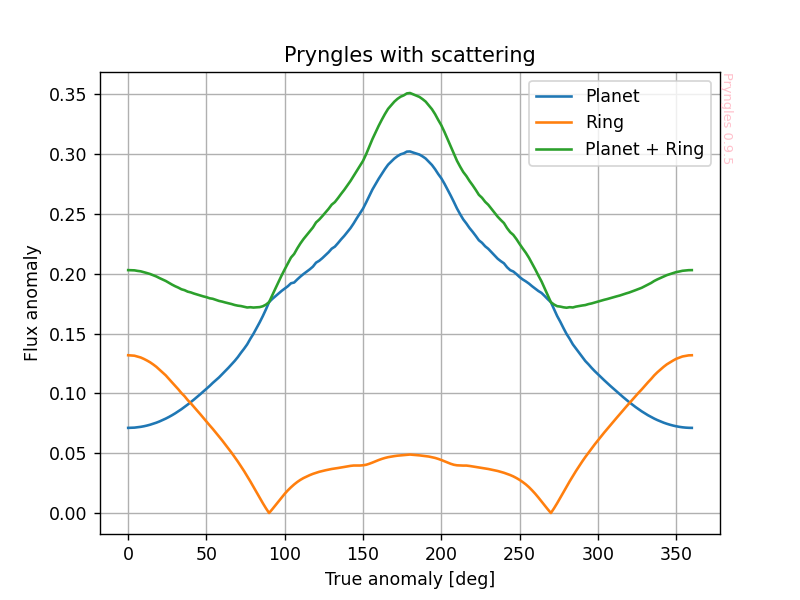

In [11]:
#Plot
fig=plt.figure()
ax=fig.gca()
ax.plot(lambs*180/np.pi-90,Rps_test,label="Planet")
ax.plot(lambs*180/np.pi-90,Rrs_test,label="Ring")
ax.plot(lambs*180/np.pi-90,Rps_test+Rrs_test,label="Planet + Ring")
ax.set_xlabel("True anomaly [deg]")
ax.set_ylabel("Flux anomaly")
ax.set_title("Pryngles with scattering")
ax.legend();
Plot.pryngles_mark(ax)
ax.grid()

Degree of polarization:

<IPython.core.display.Javascript object>


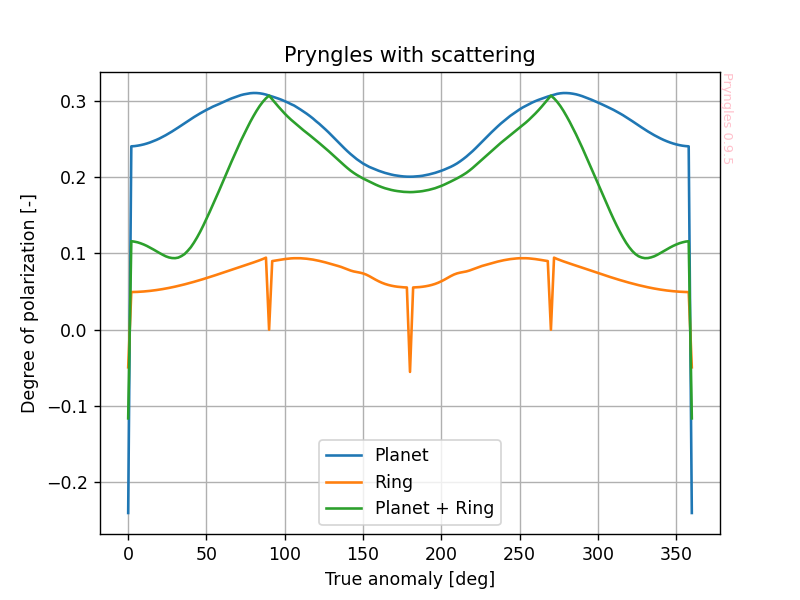

In [12]:
fig=plt.figure()
ax=fig.gca()
ax.plot(lambs*180/np.pi-90,Pp,label="Planet")
ax.plot(lambs*180/np.pi-90,Pr,label="Ring")
ax.plot(lambs*180/np.pi-90,Ptot,label="Planet + Ring")
ax.set_xlabel("True anomaly [deg]")
ax.set_ylabel("Degree of polarization [-]")
ax.set_title("Pryngles with scattering")
ax.legend();
ax.grid()
Plot.pryngles_mark(ax)
plt.show()

Components of the Stokes vector:

<IPython.core.display.Javascript object>


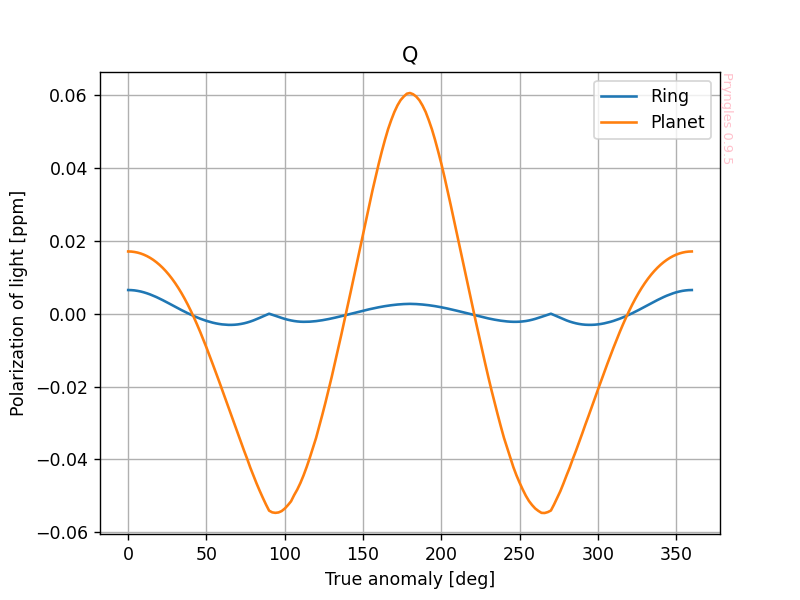

In [13]:
fig=plt.figure()
ax=fig.gca()
ax.plot(lambs*180/np.pi-90,Qr,label="Ring")
ax.plot(lambs*180/np.pi-90,Qp,label="Planet")
ax.set_xlabel("True anomaly [deg]")
ax.set_ylabel("Polarization of light [ppm]")
ax.set_title("Q")
ax.legend();
ax.grid()
Plot.pryngles_mark(ax)
plt.show()

<IPython.core.display.Javascript object>


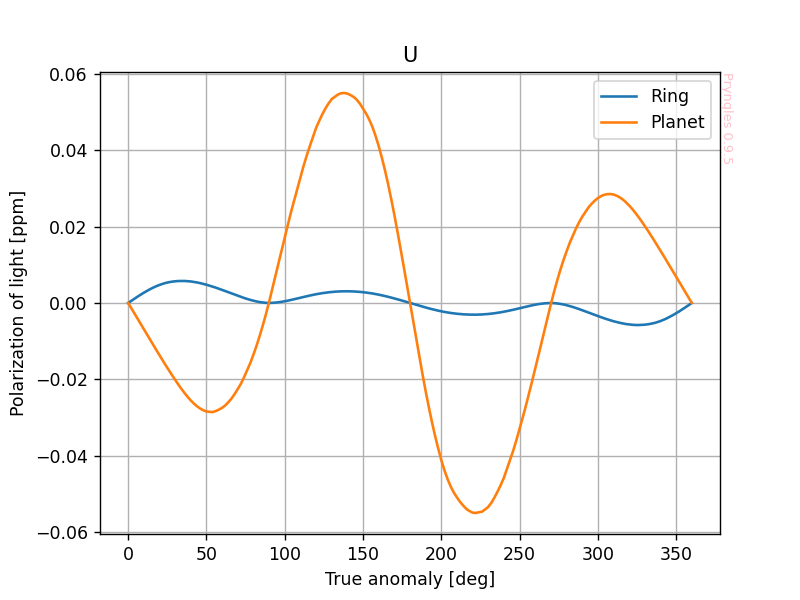

In [14]:
fig=plt.figure()
ax=fig.gca()
ax.plot(lambs*180/np.pi-90,Ur,label="Ring")
ax.plot(lambs*180/np.pi-90,Up,label="Planet")
ax.set_xlabel("True anomaly [deg]")
ax.set_ylabel("Polarization of light [ppm]")
ax.set_title("U")
ax.legend();
ax.grid()
Plot.pryngles_mark(ax)
plt.show()

<IPython.core.display.Javascript object>


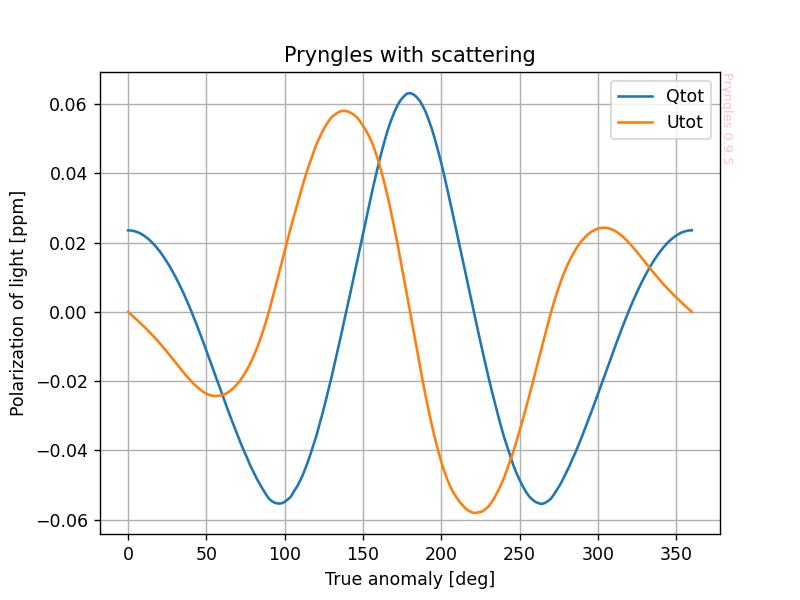

In [15]:
fig=plt.figure()
ax=fig.gca()
ax.plot(lambs*180/np.pi-90,Qtot,label="Qtot")
ax.plot(lambs*180/np.pi-90,Utot,label="Utot")
ax.set_xlabel("True anomaly [deg]")
ax.set_ylabel("Polarization of light [ppm]")
ax.set_title("Pryngles with scattering")
ax.legend();
ax.grid()
Plot.pryngles_mark(ax)
plt.show()

## Generate systems with rolled rings

In the legacy module it is not possible to rotate the longitude of the ring-plane crossing directly by rolling the ring. Instead the observer needs to be moved to account for the correct longitude of the ring-plane crossing. To make the process easier of orienting the observer and the inclination of the ring. These values can be generated using a function from the Utils class. 

Given a set of parameters for the system: orbit inclination, ring inclination(with respect to the observer) and ring longitudinal roll(also with respect to the observer)

In [16]:
RAD = 180/np.pi
orbit_i = 30 # 90 is edge-on, 0 is face-on
ring_i = 60 # 90 is edge-on, 0 is face-on
ring_l = 60
gamma, beta_obs, lamb_obs, lamb_star = Util.calcStartingPosition(orbit_i,ring_i,ring_l)
print("Ring inclination: ", gamma*RAD, "Observer inclination: ", beta_obs*RAD, "Observer longitude: ", lamb_obs*RAD, 
      "Starting true anomaly: ", lamb_star*RAD)

Ring inclination:  49.49464973516679 Observer inclination:  59.999999931439994 Observer longitude:  -55.284996163184395 Starting true anomaly:  124.71500420409342


Generate the system:

In [17]:
sys_test = System()

s=sys_test.add(kind="Star",
          physics=dict(radius=Consts.rsun/sys_test.ul),
          optics=dict(limb_coeffs=[0.65]))
p=sys_test.add(kind="Planet", primary=s,
          orbit=dict(a=3, e=0.0), 
          physics=dict(radius=Consts.rsaturn/sys_test.ul),
          optics=dict(nspangles=5000))
r=sys_test.add(kind="Ring", primary=p,
          physics=dict(fi=1.5, fe=2.25, i=gamma),
          optics=dict(nspangles=5000))
o=sys_test.add(kind="Observer",
          optics=dict(lamb=lamb_obs, beta=beta_obs))
RP_test=sys_test.ensamble_system(extension=extension)

Let's see what we have changed:

<IPython.core.display.Javascript object>


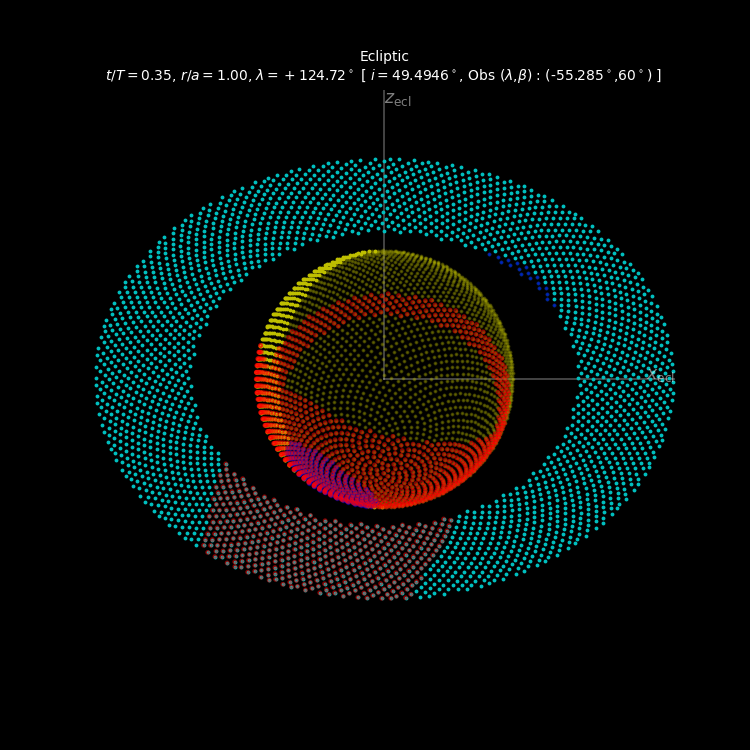

<IPython.core.display.Javascript object>


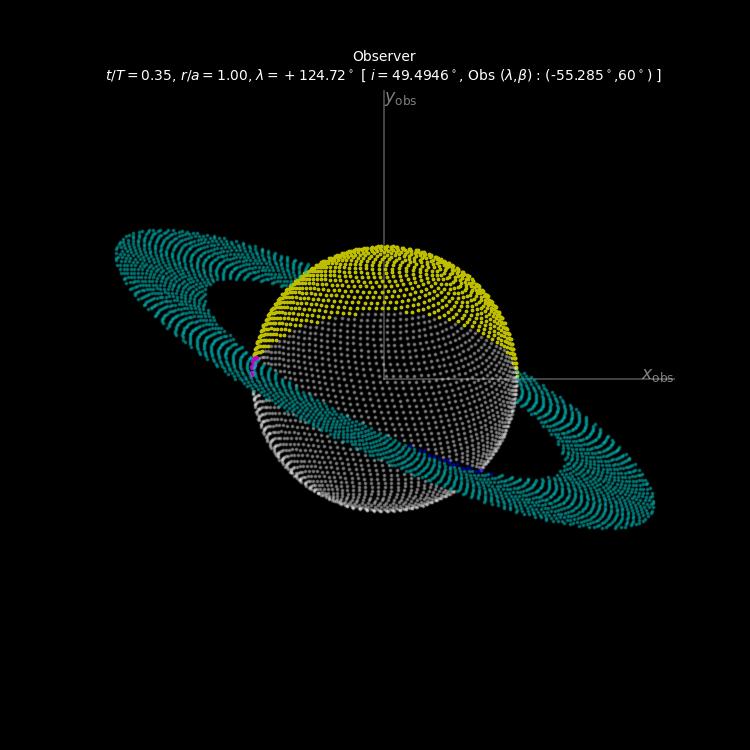

<IPython.core.display.Javascript object>


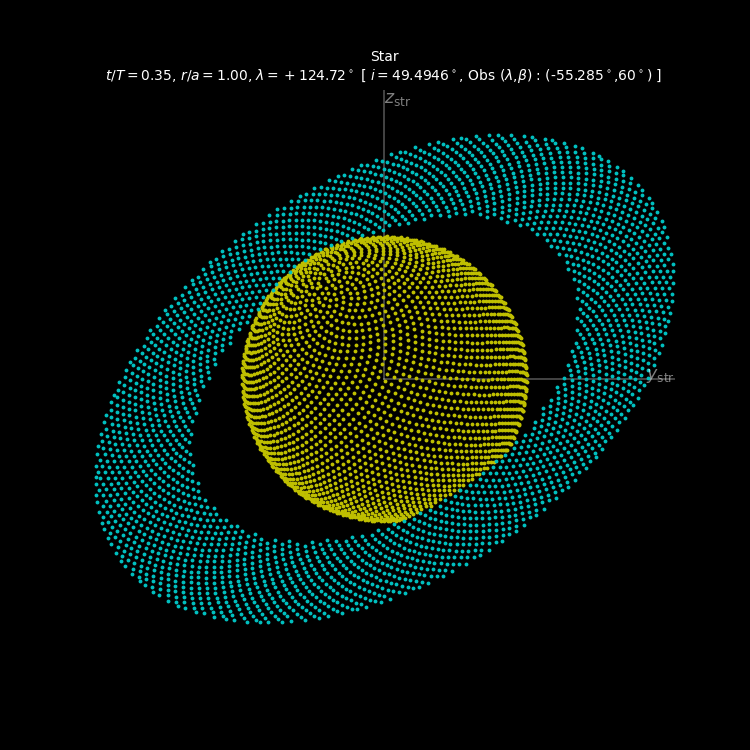

(<Figure size 600x600 with 1 Axes>,
 <Figure size 600x600 with 1 Axes>,
 <Figure size 600x600 with 1 Axes>)

In [18]:
RP_test.changeStellarPosition(lamb_star)
RP_test.changeObserver([lamb_obs, beta_obs])
RP_test._updateGeometricalFactors()
RP_test.plotRingedPlanet(showstar=True)

Now let's see what kind of difference that makes in the calculated fluxes

In [19]:
lamb_initial=lamb_star
lamb_final=lamb_initial+360*Consts.deg
lambs=np.linspace(lamb_initial,lamb_final,361)

# New
Rps_test=[]
Rrs_test=[]
Pp = []
Pr = []
Ptot=[]
Qr=[]
Qp=[]
Qtot=[]
Ur=[]
Up=[]
Utot=[]
alpha=[]
ts_test=[]
Tp_test = []
Tr_test = []
T_test = []


reflec_time = []
for lamb in tqdm(lambs):
    st = time.time()
    RP_test.changeStellarPosition(lamb)
    ts_test+=[RP_test.t*RP_test.CU.UT]

    RP_test.updateOpticalFactors()
    et = time.time()
    
    st = time.time()
    RP_test.updateReflection()
    et = time.time()
    reflec_time += [et-st]
    
    Rps_test+=[RP_test.Rip.sum()]
    Rrs_test+=[RP_test.Rir.sum()]
    Pp += [RP_test.Ptotp]
    Pr += [RP_test.Ptotr]
    Ptot+=[RP_test.Ptot]
    Qr+=[RP_test.Stotr[1]]
    Qp+=[RP_test.Stotp[1]]
    Qtot+=[RP_test.Stot[1]]
    Ur+=[RP_test.Stotr[2]]
    Up+=[RP_test.Stotp[2]]
    Utot+=[RP_test.Stot[2]]
    alpha+=[np.arccos(RP_test.alphaps)*180/np.pi]

100%|██████████| 361/361 [00:29<00:00, 12.41it/s]


In [20]:
# New
ts_test=np.array(ts_test)
Rps_test=np.array(Rps_test)
Rrs_test=np.array(Rrs_test)
Pp=np.array(Pp)
Pr=np.array(Pr)
Ptot=np.array(Ptot)
Qr=np.array(Qr)
Qp=np.array(Qp)
Qtot=np.array(Qtot)
Ur=np.array(Ur)
Up=np.array(Up)
Utot=np.array(Utot)
alpha=np.array(alpha)
Tp_test = np.array(Tp_test)
Tr_test = np.array(Tr_test)
T_test = np.array(T_test)

ind = np.argmax(alpha)
indstart = np.argsort(alpha)[0]

reflec_time = np.array(reflec_time)
print("Average reflection time: ", np.mean(reflec_time))

ts_test=(ts_test-ts_test[0])/Consts.day

Average reflection time:  0.06949517667458659


Flux curves:

<IPython.core.display.Javascript object>


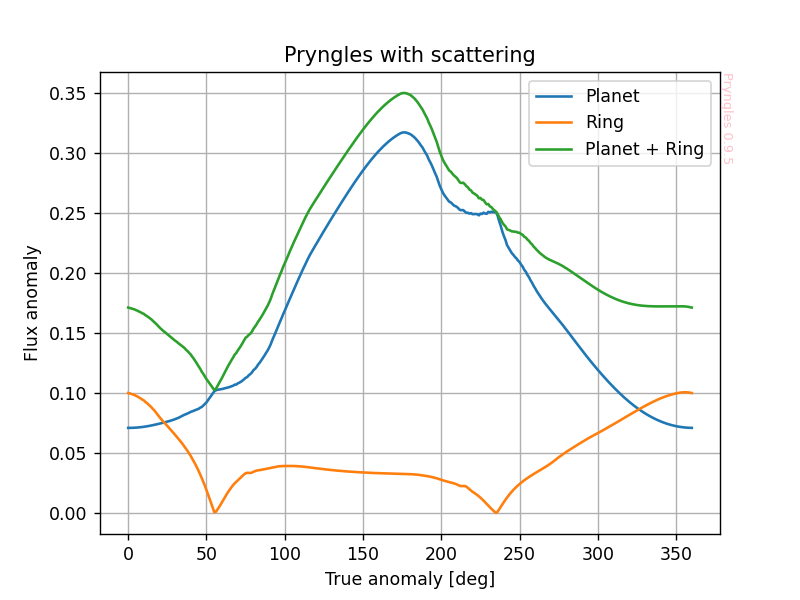

In [21]:
#Plot
fig=plt.figure()
ax=fig.gca()
ax.plot((lambs-lamb_star)*180/np.pi,Rps_test,label="Planet")
ax.plot((lambs-lamb_star)*180/np.pi,Rrs_test,label="Ring")
ax.plot((lambs-lamb_star)*180/np.pi,Rps_test+Rrs_test,label="Planet + Ring")
ax.set_xlabel("True anomaly [deg]")
ax.set_ylabel("Flux anomaly")
ax.set_title("Pryngles with scattering")
ax.legend();
Plot.pryngles_mark(ax)
ax.grid()

Degree of polarization:

<IPython.core.display.Javascript object>


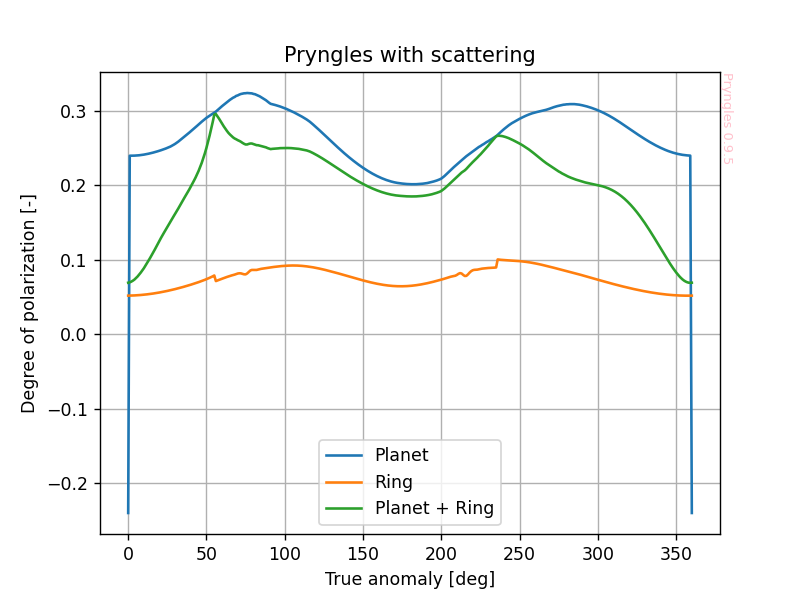

In [22]:
fig=plt.figure()
ax=fig.gca()
ax.plot((lambs-lamb_star)*180/np.pi,Pp,label="Planet")
ax.plot((lambs-lamb_star)*180/np.pi,Pr,label="Ring")
ax.plot((lambs-lamb_star)*180/np.pi,Ptot,label="Planet + Ring")
ax.set_xlabel("True anomaly [deg]")
ax.set_ylabel("Degree of polarization [-]")
ax.set_title("Pryngles with scattering")
ax.legend();
ax.grid()
Plot.pryngles_mark(ax)
plt.show()

Components of the Stokes vector:

<IPython.core.display.Javascript object>


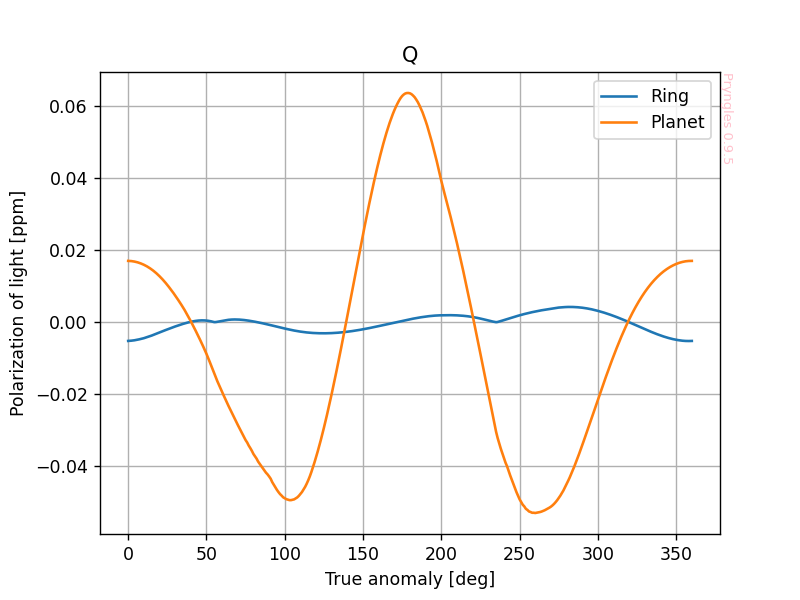

In [23]:
fig=plt.figure()
ax=fig.gca()
ax.plot((lambs-lamb_star)*180/np.pi,Qr,label="Ring")
ax.plot((lambs-lamb_star)*180/np.pi,Qp,label="Planet")
ax.set_xlabel("True anomaly [deg]")
ax.set_ylabel("Polarization of light [ppm]")
ax.set_title("Q")
ax.legend();
ax.grid()
Plot.pryngles_mark(ax)
plt.show()

<IPython.core.display.Javascript object>


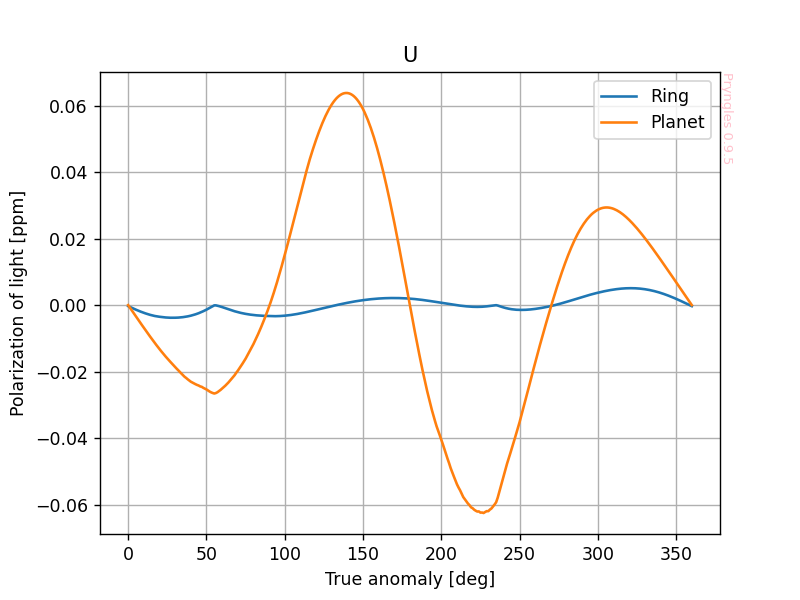

In [24]:
fig=plt.figure()
ax=fig.gca()
ax.plot((lambs-lamb_star)*180/np.pi,Ur,label="Ring")
ax.plot((lambs-lamb_star)*180/np.pi,Up,label="Planet")
ax.set_xlabel("True anomaly [deg]")
ax.set_ylabel("Polarization of light [ppm]")
ax.set_title("U")
ax.legend();
ax.grid()
Plot.pryngles_mark(ax)
plt.show()

<IPython.core.display.Javascript object>


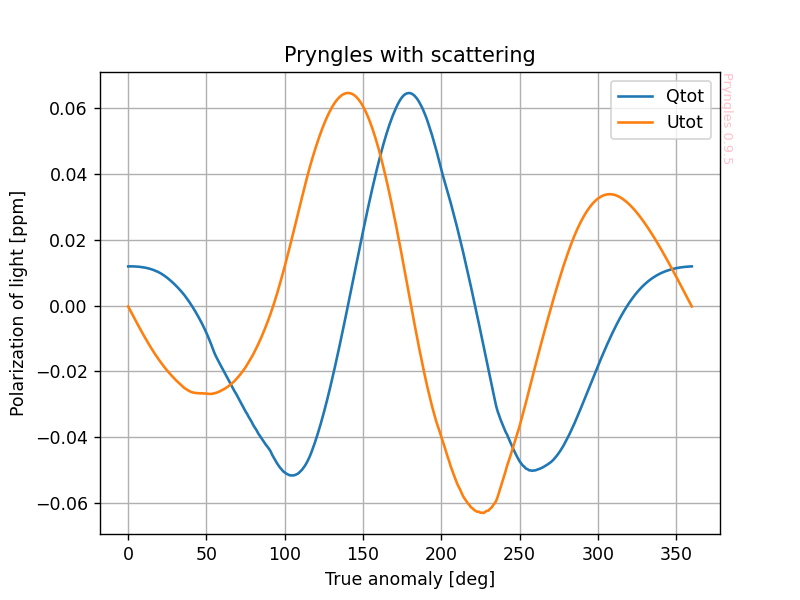

In [25]:
fig=plt.figure()
ax=fig.gca()
ax.plot((lambs-lamb_star)*180/np.pi,Qtot,label="Qtot")
ax.plot((lambs-lamb_star)*180/np.pi,Utot,label="Utot")
ax.set_xlabel("True anomaly [deg]")
ax.set_ylabel("Polarization of light [ppm]")
ax.set_title("Pryngles with scattering")
ax.legend();
ax.grid()
Plot.pryngles_mark(ax)
plt.show()

--- 
*The authors*, Last update: december, 2022.